**Part 3 - Looseness prediction**

Paulo Yoshio Kuga

In [12]:
import pandas as pd
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import re
import ast



from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

*1. Extract features that might be relevant for distinguishing between a healthy and loose asset. Plot the features from the dataset using any data visualization you find relevant.*

First, we load the metadata, and using it, we can load the real data.

In [3]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

dataDict = {sample_id: pd.read_csv(path + "data/" + sample_id + ".csv") for sample_id in metadata["sample_id"]}

for i,file in metadata.iterrows():
    data = dataDict[file["sample_id"]]
    data.set_index("X-Axis", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictChannel[name]] for name in data.columns]

    

In [4]:
def GenerateWelch(data,nperseg = 1024, overlap_factor = 0.75, windowP="hann" ):

    nover = int(nperseg*overlap_factor)

    data = data - data.mean()
   

    fs = data.shape[0] / data.index.max() 

    f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')

    return f, Ph, Pv, Pa

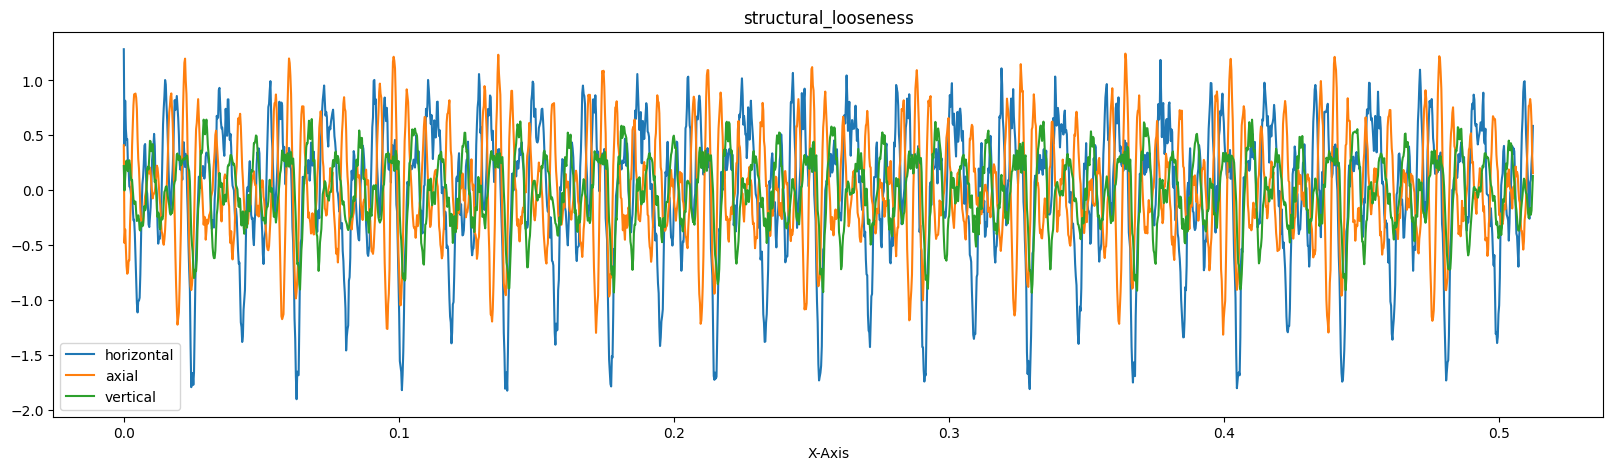

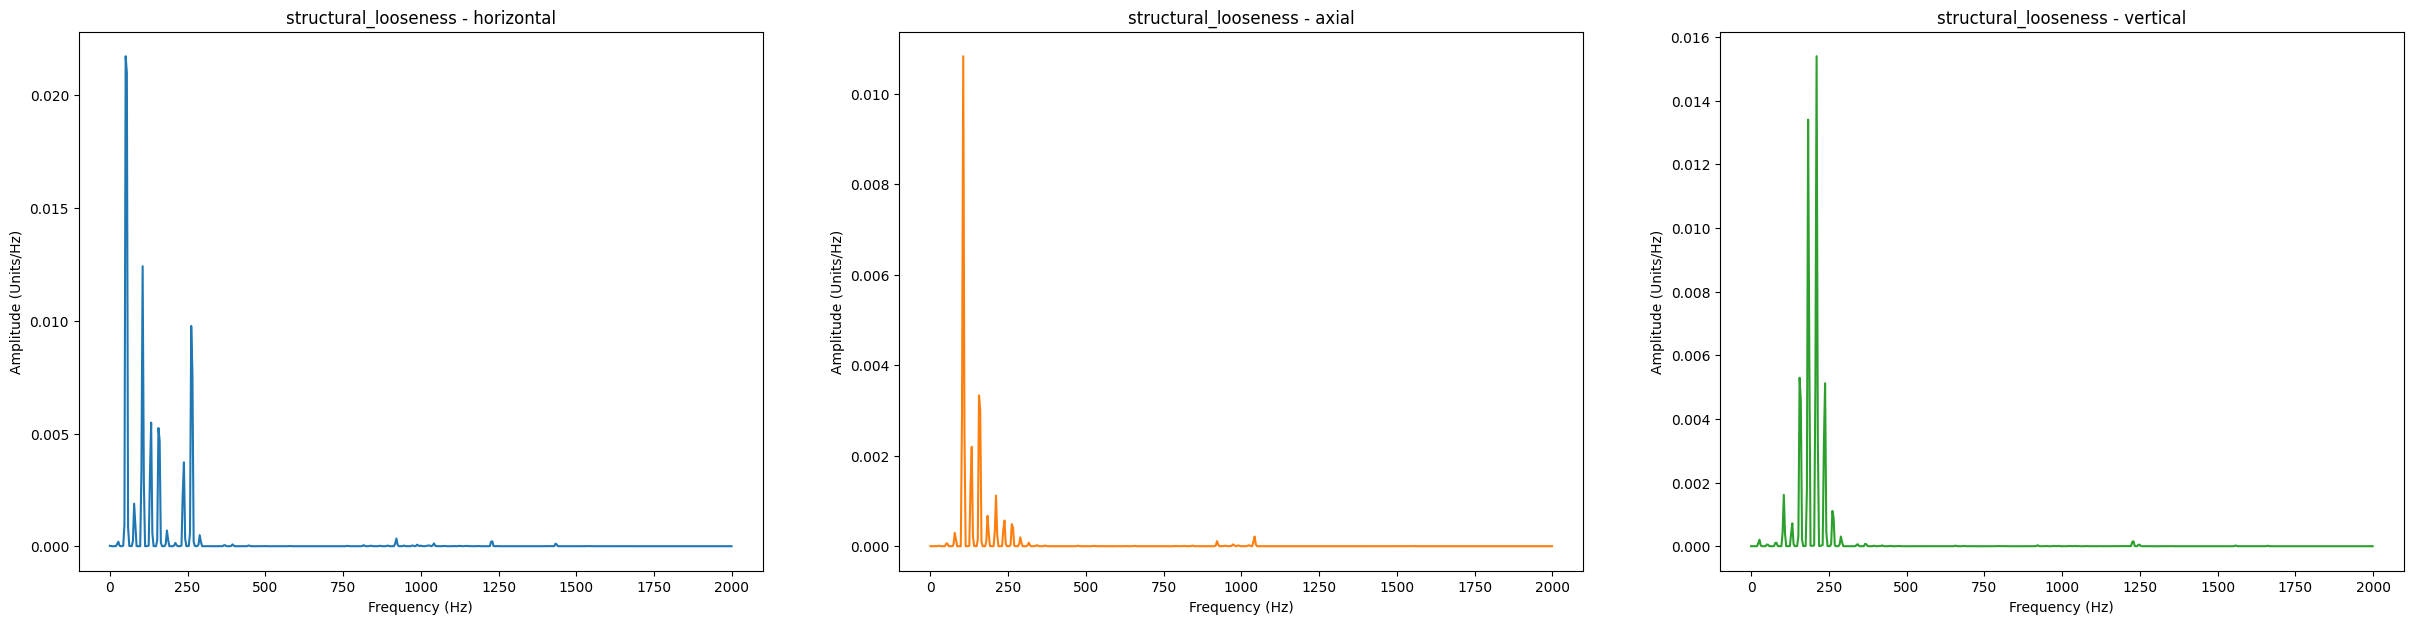

In [5]:
i = 15
w = 1024
data = dataDict[metadata["sample_id"][i]]

data.plot(figsize=(20,5))
plt.title(metadata["condition"][i])

f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w,overlap_factor=0.5)
P_g = np.array([Ph, Pv, Pa])

fig, axs = plt.subplots(1, 3, figsize=(30, 7))
for j, ax in enumerate(axs):
    ax.plot(f, P_g[j], color='C'+str(j))
    ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')

In [ ]:
# def condition_mean(metadata, condition,dataDict,npserseg=1024):
    
#     mean = np.zeros(3)
#     for i,file in enumerate(metadata.loc[
#         metadata["condition"]==condition
#         ,"sample_id"]):
        
#         f,Ph, Pv, Pa  = GenerateWelch(dataDict[file],nperseg=npserseg,overlap_factor=0.5)
#         deltaF = f[1]-f[0]
#         mean += np.sum(np.array([Ph, Pv, Pa]),axis=1)*deltaF
#     return mean/i   

#healthy - array([0.39794211, 0.09247082, 0.28614568])

#structural looseness - array([0.23152277, 0.21182025, 0.6512794 ])

# mean_healthy = condition_mean(metadata,"structural_looseness",dataDict)
# mean_structural = condition_mean(metadata,"structural_looseness",dataDict)

In [45]:
def SampleEnergy(data,nperseg=1024,overlap_factor=0.5):
    f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=nperseg,overlap_factor=overlap_factor)
    return np.mean(np.log10(np.array([Ph, Pv, Pa])),axis=1)*(f[1]-f[0])


In [44]:
SampleEnergy(data)

array([-26.32163664, -34.42313163, -28.46132579])

In [46]:
dataset = metadata[["sample_id","condition"]].copy()
dataset[["Eh","Ev","Ea"]] = 0

for i,row in dataset.iterrows():
    row.loc[["Eh","Ev","Ea"]] = SampleEnergy(dataDict[row["sample_id"]])

In [47]:
def get_energies(sample_id):
    return pd.Series(SampleEnergy(dataDict[sample_id]), index=["Eh","Ev","Ea"])

dataset = metadata[["sample_id","condition"]].copy()
dataset[["Eh","Ev","Ea"]] = dataset["sample_id"].apply(get_energies)

X = dataset[["Eh","Ev","Ea"]]
y = dataset["condition"]
           
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=199712115)

In [48]:
pipeToKnn = Pipeline(    
    steps=[
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier()
         )
         ]
)


#parameters to be tested
param_grid = {
    "knn__n_neighbors": np.array(list(range(1, 30))),  
    "knn__weights": ["uniform", "distance"]
}

# otimizador com validação cruzada
grid = GridSearchCV(
    pipeToKnn,
    param_grid,
    cv=5, #10 fold had not changed f1                 
    scoring="f1_macro" #macro or weighted?
)

grid.fit(X_train, y_train)

print("Parameters:", grid.best_params_)
print("F1 Score:", grid.best_score_)

pipeToKnn.set_params(**grid.best_params_)

Parameters: {'knn__n_neighbors': np.int64(4), 'knn__weights': 'distance'}
F1 Score: 0.8652396473506352


,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,np.int64(4)
,weights,'distance'
,algorithm,'auto'
,leaf_size,30


In [49]:
pipeToKnn.fit(X_train,y_train)

y_hat = pipeToKnn.predict(X_test)

print(classification_report(y_test, y_hat))

                      precision    recall  f1-score   support

             healthy       0.83      0.75      0.79        20
structural_looseness       0.89      0.93      0.91        43

            accuracy                           0.87        63
           macro avg       0.86      0.84      0.85        63
        weighted avg       0.87      0.87      0.87        63



In [41]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed
        self.params = params
    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:
        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """
        raise NotImplementedError("The 'predict' method must be implemented.")
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        raise NotImplementedError("The 'score' method must be implemented.")

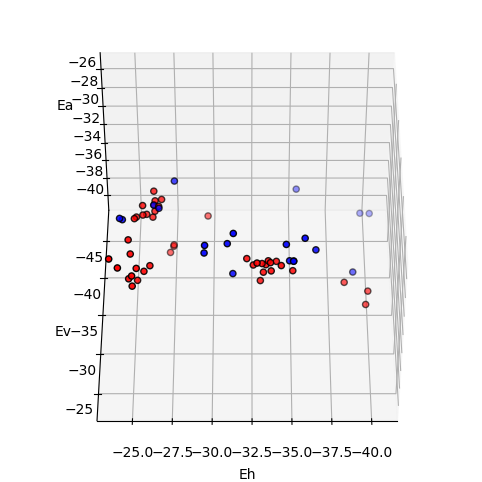

In [42]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Mapear cores pelas classes previstas
colors = {"healthy": "blue", "structural_looseness": "red"}
ax.scatter(X_test["Eh"], X_test["Ev"], X_test["Ea"],
           c=[colors[label] for label in y_test],
           marker="o", s=20, edgecolor="k")

ax.set_xlabel("Eh")
ax.set_ylabel("Ev")
ax.set_zlabel("Ea")
ax.view_init(elev=45, azim=90)
#ax.set_title(f"k-NN classification (k={10}, weights='{weights}')")